In [1]:
# Install the required libraries
!pip install torch_geometric       # Provides tools and layers for building Graph Neural Networks
!pip install optuna                # Library for hyperparameter tuning (not used yet in the notebook)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.0 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import KarateClub  # Loads a classic social network dataset
from torch_geometric.utils import to_networkx    # Converts PyTorch Geometric data to NetworkX
import networkx as nx                            # For graph visualization and manipulation
import matplotlib.pyplot as plt                  # For plotting graphs
import numpy as np                               # For numerical operations
from torch.nn import Linear                      # Linear layer for neural networks
from torch_geometric.nn import GCNConv           # Graph Convolutional Layer


In [3]:
# Load the Karate Club dataset
dataset = KarateClub()        # Downloads and loads the graph data
data = dataset[0]             # Retrieves the first graph (only one in this dataset)


In [4]:
print(dataset.num_features)  # Prints the number of features per node (usually 34 for this dataset)


34


In [5]:
import pandas as pd

# Convert node features to a pandas DataFrame
node_features_df = pd.DataFrame(
    data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])]
)  # Each row = a node, columns = node features

node_features_df['node'] = node_features_df.index        # Add node index as a column
node_features_df.set_index('node', inplace=True)         # Set node index as DataFrame index

# Convert edge indices to a pandas DataFrame
edge_index_df = pd.DataFrame(
    data.edge_index.numpy().T, columns=['source', 'target']
)  # Edge list where each row is an edge

# Convert labels to a pandas DataFrame
labels_df = pd.DataFrame(data.y.numpy(), columns=['label'])  # Node labels (e.g., class or group)
labels_df['node'] = labels_df.index                          # Add node index
labels_df.set_index('node', inplace=True)                    # Set as index


In [6]:
print(node_features_df)  # Displays all node features stored in the DataFrame


      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   
5           0.0        0.0        0.0        0.0        0.0        1.0   
6           0.0        0.0        0.0        0.0        0.0        0.0   
7           0.0        0.0        0.0        0.0        0.0        0.0   
8           0.0        0.0        0.0        0.0        0.0        0.0   
9           0.0        0.0        0.0        0.0        0.0        0.0   
10          0.0        0.0        0.0        0.0        0.0        0.0   
11          0.0        0.0        0.0 

In [7]:
# Print the number of nodes
num_nodes = data.num_nodes  # Accesses the number of nodes in the graph
print(f"Number of nodes: {num_nodes}")


Number of nodes: 34


In [8]:
# Print the number of edges
num_edges = data.edge_index.shape[1]  # Edge index is a 2xE tensor; shape[1] = number of edges
print(f"Number of edges: {num_edges}")


Number of edges: 156


In [9]:
# Print node features DataFrame
print(f"\nNode features (shape: {node_features_df.shape}):")  # Shows shape of the DataFrame
print(node_features_df.head())  # Show the first few rows for inspection



Node features (shape: (34, 34)):
      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   

      feature_6  feature_7  feature_8  feature_9  ...  feature_24  feature_25  \
node                                              ...                           
0           0.0        0.0        0.0        0.0  ...         0.0         0.0   
1           0.0        0.0        0.0        0.0  ...         0.0         0.0   
2           0.0        0.0        0.0        0.0  ...         0.0         0.0   
3           0.0        0.0        0.0     

In [10]:
# Print edge indices DataFrame
print(f"\nEdge indices (shape: {edge_index_df.shape}):")  # Shows shape (num_edges x 2)
print(edge_index_df.head())  # Print first few edges



Edge indices (shape: (156, 2)):
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [11]:
# Print labels DataFrame
print(f"\nLabels (shape: {labels_df.shape}):")  # Show how many node labels are present
print(labels_df.head())  # Show first few labels



Labels (shape: (34, 1)):
      label
node       
0         1
1         1
2         1
3         1
4         3


In [12]:
# Number of countries
num_countries = 4  # Define 4 country categories for the classification task

# Assign students to countries (labels)
np.random.seed(42)  # Fix randomness for reproducibility
countries = torch.tensor(np.random.choice(num_countries, data.num_nodes))
# Assign a random country label to each node

# Update the labels in the data object
data.y = countries  # Replace the old labels with new "country" labels


In [13]:
# Verify the data
print(data)  # Overview of graph data object
print(f'x = {data.x.shape}')  # Shape of node feature matrix
print(data.x)  # Print node features
print(f'edge_index = {data.edge_index.shape}')  # Shape of edge list (2, num_edges)
print(data.edge_index)  # Edge connections
print(f'y = {data.y.shape}')  # Shape of label vector
print(data.y)  # The assigned country labels


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 

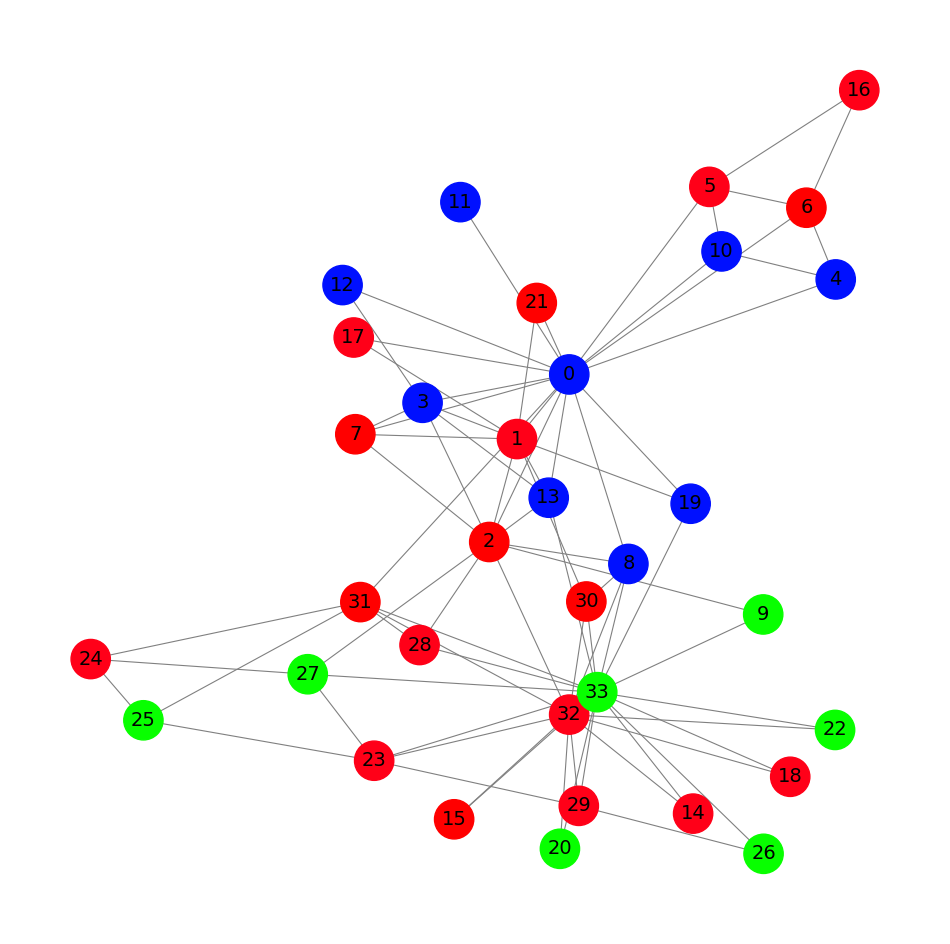

In [14]:
# Convert data to NetworkX format for visualization
G = to_networkx(data, to_undirected=True)  # Convert to undirected graph

plt.figure(figsize=(12, 12))  # Set size of plot
plt.axis('off')  # Hide axes

# Draw the graph using spring layout
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=0),  # Layout algorithm
    with_labels=True,  # Show node numbers
    node_size=800,  # Size of each node
    node_color=data.y.tolist(),  # Color each node by its label
    cmap="hsv",  # Color map
    vmin=0,      # Minimum label
    vmax=3,      # Maximum label
    width=0.8,   # Edge thickness
    edge_color="grey",  # Edge color
    font_size=14  # Label font size
)
plt.show()


In [15]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)  # GCN layer that reduces feature size to 3
        self.out = Linear(3, num_countries)          # Final classification layer

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()  # Apply GCN and ReLU
        z = self.out(h)  # Output logits for classification
        return h, z      # Return both intermediate and final outputs

model = GCN()  # Instantiate the model
print(model)   # Print model structure


GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)
